In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import datetime

In [2]:
raw = pd.read_csv("MC_freshness_data_new.csv")
raw.head()

,FULL_TABLE_ID,UPDATE_TIME,FIRST_MEASURED
0,raw:data_collector_events.bi_metadata,2022-03-29 05:48:00.000,2022-03-29 06:16:37.000
1,raw:monolith_export.notificationsettings,2022-02-22 12:54:00.000,2022-02-22 13:06:16.000
2,raw:data_collector_events.retry_query_logs,2022-03-29 19:54:00.000,2022-03-29 20:28:25.000
3,raw:normalized_events.metadata_event_resolution,2022-03-29 19:54:00.000,2022-03-29 20:28:25.000
4,analytics:prod_lineage.lineage_custom_blocked_...,2022-03-14 00:58:00.000,2022-03-14 01:33:00.000


In [3]:
raw.UPDATE_TIME = pd.to_datetime(raw.UPDATE_TIME,format="%Y-%m-%d %H:%M:%S")
raw.FIRST_MEASURED = pd.to_datetime(raw.FIRST_MEASURED,format="%Y-%m-%d %H:%M:%S")
raw.head()

,FULL_TABLE_ID,UPDATE_TIME,FIRST_MEASURED
0,raw:data_collector_events.bi_metadata,2022-03-29 05:48:00,2022-03-29 06:16:37
1,raw:monolith_export.notificationsettings,2022-02-22 12:54:00,2022-02-22 13:06:16
2,raw:data_collector_events.retry_query_logs,2022-03-29 19:54:00,2022-03-29 20:28:25
3,raw:normalized_events.metadata_event_resolution,2022-03-29 19:54:00,2022-03-29 20:28:25
4,analytics:prod_lineage.lineage_custom_blocked_...,2022-03-14 00:58:00,2022-03-14 01:33:00


<AxesSubplot:ylabel='Frequency'>

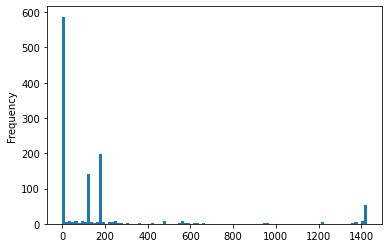

In [4]:
raw.groupby('FULL_TABLE_ID')['UPDATE_TIME'].count().plot(kind="hist",bins=100)

In [5]:
raw[raw.FIRST_MEASURED < raw.UPDATE_TIME].shape[0] / raw.shape[0]
# ok, seems to be a bug, let's drop it

0.006259953380980983

In [6]:
raw = raw[raw.FIRST_MEASURED >= raw.UPDATE_TIME]
raw.head()

,FULL_TABLE_ID,UPDATE_TIME,FIRST_MEASURED
0,raw:data_collector_events.bi_metadata,2022-03-29 05:48:00,2022-03-29 06:16:37
1,raw:monolith_export.notificationsettings,2022-02-22 12:54:00,2022-02-22 13:06:16
2,raw:data_collector_events.retry_query_logs,2022-03-29 19:54:00,2022-03-29 20:28:25
3,raw:normalized_events.metadata_event_resolution,2022-03-29 19:54:00,2022-03-29 20:28:25
4,analytics:prod_lineage.lineage_custom_blocked_...,2022-03-14 00:58:00,2022-03-14 01:33:00


<AxesSubplot:ylabel='Frequency'>

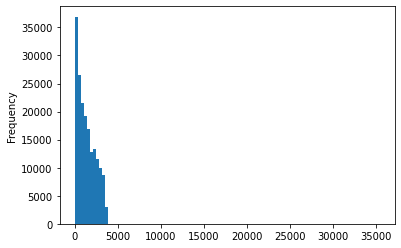

In [7]:
(raw.FIRST_MEASURED - raw.UPDATE_TIME).dt.total_seconds().plot(kind="hist",bins=100)

<AxesSubplot:title={'center':'tail of hours until sampled'}>

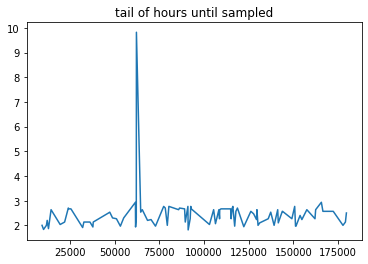

In [8]:
# looking at the long tail
raw['seconds_between_sampling'] = (raw.FIRST_MEASURED - raw.UPDATE_TIME).dt.total_seconds()
(raw[(raw.seconds_between_sampling > 5000)]['seconds_between_sampling'] / (60*60)).plot(title="tail of hours until sampled")

In [9]:
raw[raw['seconds_between_sampling'] > 3*60*60]
# don't know yet what to do with this anomaliy, what this indicate except long time any MC system checked this table? 
# possible issue with MC systems.

,FULL_TABLE_ID,UPDATE_TIME,FIRST_MEASURED,seconds_between_sampling
62195,ingest:spark.query_logs,2022-03-20 03:10:00,2022-03-20 12:59:17,35357.0


In [10]:
raw.groupby("FULL_TABLE_ID")['FIRST_MEASURED'].agg(['min','max'])
# ok! it seeme that we are measueing only for about two months.

,min,max
FULL_TABLE_ID,,
ANALYTICS:DBT_DDABUSH_INTERNAL_BI_STAGE.SALESFORCE_Weighted_Pipeline,2022-03-15 14:07:00,2022-03-29 16:24:01
ANALYTICS:DBT_DDABUSH_INTERNAL_BI_STAGE.SALESFORCE_Weighted_Pipeline_dates,2022-03-15 15:08:22,2022-03-29 16:24:01
analytics:dbt_aliu.kargo_bi,2022-03-23 23:17:14,2022-03-23 23:17:14
analytics:dbt_aliu.table_metadata,2022-02-23 17:34:09,2022-02-23 17:34:09
analytics:dbt_aliu_lineage.looker_nodes,2022-03-21 18:26:59,2022-03-21 22:31:12
...,...,...
raw:normalized_events.size,2022-02-04 16:18:18,2022-04-05 14:43:57
raw:normalized_events.spark_lineage,2022-02-04 16:18:18,2022-04-05 14:43:57
raw:spark.query_logs,2022-02-04 16:18:18,2022-04-05 14:43:57


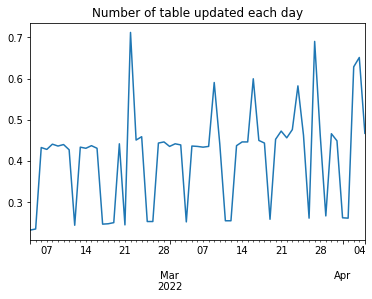

In [11]:
number_of_series = raw['FULL_TABLE_ID'].nunique()
series_updates = raw.groupby(raw.UPDATE_TIME.dt.date)['FULL_TABLE_ID'].nunique()
series_updates = series_updates.reindex(pd.date_range(series_updates.index.min(),series_updates.index.max(),freq='D'),fill_value=0)
_=(series_updates/number_of_series).plot(title="Number of table updated each day")

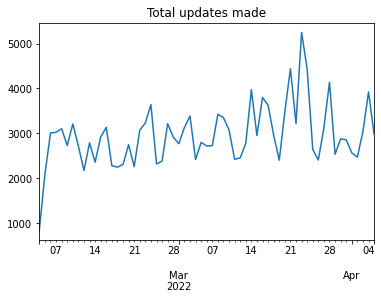

In [12]:
global_updates = raw.UPDATE_TIME.dt.date.value_counts()
global_updates = global_updates.reindex(pd.date_range(global_updates.index.min(),global_updates.index.max(),freq='D'),fill_value=0)
_=global_updates.plot(title="Total updates made")
# assuming this is one customer, there are alot of updates at this spike at the end
# also, at the start there is only about 1000 updates, possiblly due to system bootstap 

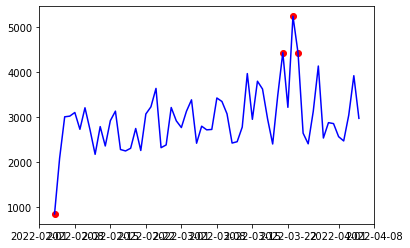

In [13]:
# this can be discribed by the following plot (which fit my intuition)
mean = global_updates.mean()
std = global_updates.std()

lower_bound = mean - 2*std
upper_bound = mean + 2*std


global_updates = global_updates.sort_index()
fig, ax = plt.subplots()

global_lower_update_anom = global_updates[(global_updates < lower_bound) ]  #anomaly
global_upper_update_anom = global_updates[(global_updates > upper_bound)]

ax.plot(global_updates.index, global_updates.values,color='blue')
ax.scatter(global_lower_update_anom.index,global_lower_update_anom.values, color='red')
ax.scatter(global_upper_update_anom.index,global_upper_update_anom.values, color='red')

plt.show()

# while those are not single update events that are anomolos, we can still use this information to notify the customer 
# or we can use is to as filter to find the exact anomaly.

In [14]:
global_upper_update_anom
# those are dates where there was to much updates

2022-03-21    4438
2022-03-23    5247
2022-03-24    4431
Name: UPDATE_TIME, dtype: int64

In [15]:
global_lower_update_anom
# those are dates where there was to little update

2022-02-04    848
Freq: D, Name: UPDATE_TIME, dtype: int64

In [16]:
def find_anomalies_by_standard_daily_updates(df,num_std=2,upper=True,lower=True):
    if not df.empty:
        df_count = df.UPDATE_TIME.dt.date.value_counts()
        df_count = df_count.reindex(pd.date_range(df_count.index.min(),df_count.index.max(),freq='D'),fill_value=0)

        mean = df_count.mean()
        std = df_count.std()

        lower_bound = mean - num_std*std
        upper_bound = mean + num_std*std

        return df_count[((df_count < lower_bound) & lower) | ((df_count > upper_bound) & upper)]        


In [19]:
upper_all_anom = raw.groupby('FULL_TABLE_ID').apply(find_anomalies_by_standard_daily_updates,lower=False)
upper_all_anom = upper_all_anom.reset_index().rename(columns={"level_1":"date","UPDATE_TIME":"num_of_update"})
upper_all_anom.head()

,FULL_TABLE_ID,date,num_of_update
0,ANALYTICS:DBT_DDABUSH_INTERNAL_BI_STAGE.SALESF...,2022-03-29,2
1,analytics:dbt_apeltinovich.active_collectors,2022-02-22,1
2,analytics:dbt_apeltinovich.active_collectors,2022-03-09,1
3,analytics:dbt_apeltinovich.active_collectors,2022-03-16,1
4,analytics:dbt_apeltinovich.active_collectors,2022-03-24,1


In [21]:
upper_all_anom[upper_all_anom.date.isin(global_upper_update_anom.index)].groupby("date")['num_of_update'].agg(['sum'])
# this explain the peak in the join series

,sum
date,
2022-03-21,1999
2022-03-23,2999
2022-03-24,1900


In [26]:
upper_all_anom[upper_all_anom.date.isin(global_upper_update_anom.index)]['FULL_TABLE_ID'].nunique()/raw[raw['UPDATE_TIME'].dt.date.isin(global_upper_update_anom.index)]['FULL_TABLE_ID'].nunique()
# we see the increase across multiple series which are more then 67% of the series we have
# do the anomalies in this day can be considered as false positive.


/Users/serlich/Documents/Notebooks/env/lib/python3.8/site-packages/pandas/core/algorithms.py:521: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  return f(comps, values)


0.6739469578783152

In [325]:
upper_all_anom[~upper_all_anom.date.isin(global_upper_update_anom.index)]
# we still need to check this.

,index,FULL_TABLE_ID,date,UPDATE_TIME
0,0,ANALYTICS:DBT_DDABUSH_INTERNAL_BI_STAGE.SALESF...,2022-03-29,2
1,1,analytics:dbt_apeltinovich.active_collectors,2022-02-22,1
2,2,analytics:dbt_apeltinovich.active_collectors,2022-03-09,1
3,3,analytics:dbt_apeltinovich.active_collectors,2022-03-16,1
5,5,analytics:dbt_apeltinovich.active_collectors,2022-03-27,1
...,...,...,...,...
2314,2314,analytics:prod_stage.rca_jobs,2022-03-05,4
2316,2316,analytics:prod_stage.tableau_accounts,2022-03-04,3
2317,2317,analytics:prod_stage.tableau_accounts,2022-03-05,4
2319,2319,analytics:prod_stage.users_history,2022-03-04,3


In [30]:
lower_all_anom = raw.groupby('FULL_TABLE_ID').apply(find_anomalies_by_standard_daily_updates,upper=False)
lower_all_anom = lower_all_anom.reset_index().rename(columns={"level_1":"date","UPDATE_TIME":"num_of_updates"})
lower_all_anom.head()

,FULL_TABLE_ID,date,num_of_updates
0,analytics:prod.active_collectors,2022-02-04,1
1,analytics:prod.active_collectors,2022-03-19,1
2,analytics:prod.active_collectors,2022-03-22,1
3,analytics:prod.active_collectors,2022-04-05,1
4,analytics:prod.active_monitors,2022-02-04,1


In [32]:
lower_all_anom[lower_all_anom.date.isin(global_lower_update_anom.index)].groupby("date")['num_of_updates'].agg(['sum'])


,sum
date,
2022-02-04,829


In [40]:
lower_all_anom[lower_all_anom.date.isin(global_lower_update_anom.index)]['FULL_TABLE_ID'].nunique()/raw[raw['UPDATE_TIME'].dt.date.isin(global_lower_update_anom.index.date)]['FULL_TABLE_ID'].nunique()
# we see the decrease in 94% of the series we can say this is system bootstap and assuming this fit the start the customer data,
# we can ignore this.

0.9411764705882353

In [48]:
low_anom = lower_all_anom[~lower_all_anom.date.isin(global_lower_update_anom.index)]
low_anom.head()
# we still need to check those

,FULL_TABLE_ID,date,num_of_updates
1,analytics:prod.active_collectors,2022-03-19,1
2,analytics:prod.active_collectors,2022-03-22,1
3,analytics:prod.active_collectors,2022-04-05,1
5,analytics:prod.active_monitors,2022-02-20,1
6,analytics:prod.active_monitors,2022-03-22,1


In [125]:
mean_daily_updates = raw.groupby([raw.FULL_TABLE_ID,raw.UPDATE_TIME.dt.date])['UPDATE_TIME'].count().to_frame()
mean_daily_updates = mean_daily_updates.rename(columns={"UPDATE_TIME":"number_of_updates"}).reset_index()
mean_daily_updates.head()

,FULL_TABLE_ID,UPDATE_TIME,number_of_updates
0,ANALYTICS:DBT_DDABUSH_INTERNAL_BI_STAGE.SALESF...,2022-03-15,2
1,ANALYTICS:DBT_DDABUSH_INTERNAL_BI_STAGE.SALESF...,2022-03-22,2
2,ANALYTICS:DBT_DDABUSH_INTERNAL_BI_STAGE.SALESF...,2022-03-29,2
3,ANALYTICS:DBT_DDABUSH_INTERNAL_BI_STAGE.SALESF...,2022-03-15,1
4,ANALYTICS:DBT_DDABUSH_INTERNAL_BI_STAGE.SALESF...,2022-03-22,1


In [126]:
mean_daily_updates = mean_daily_updates.groupby("FULL_TABLE_ID").agg(['mean','std']).reset_index()#.droplevel(axis=1,level=0)
mean_daily_updates.head()

/var/folders/3r/ygns0_h16pl1__pln5g3j8t80000gp/T/ipykernel_50659/1634036407.py:1: FutureWarning: ['UPDATE_TIME'] did not aggregate successfully. If any error is raised this will raise in a future version of pandas. Drop these columns/ops to avoid this warning.
  mean_daily_updates = mean_daily_updates.groupby("FULL_TABLE_ID").agg(['mean','std']).reset_index()#.droplevel(axis=1,level=0)


FULL_TABLE_ID number_of_updates  \
                                                                  mean   
0  ANALYTICS:DBT_DDABUSH_INTERNAL_BI_STAGE.SALESF...          2.000000   
1  ANALYTICS:DBT_DDABUSH_INTERNAL_BI_STAGE.SALESF...          1.333333   
2                        analytics:dbt_aliu.kargo_bi          1.000000   
3                  analytics:dbt_aliu.table_metadata          1.000000   
4            analytics:dbt_aliu_lineage.looker_nodes          2.000000   

            
       std  
0  0.00000  
1  0.57735  
2      NaN  
3      NaN  
4      NaN

In [76]:
mean_daily_updates.mean()

6.505826328511129